In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

In [42]:
def plot_images(images, labels):
    plt.figure(figsize=(12, 12))
    for i, img in enumerate(images):
        plt.subplot(int(f'23{i+1}'))
        plt.title(str(labels[i]))
        plt.imshow(img, cmap='gray')
        plt.tick_params(left=False, right=False, 
                        labelleft=False, labelbottom=False, bottom=False)

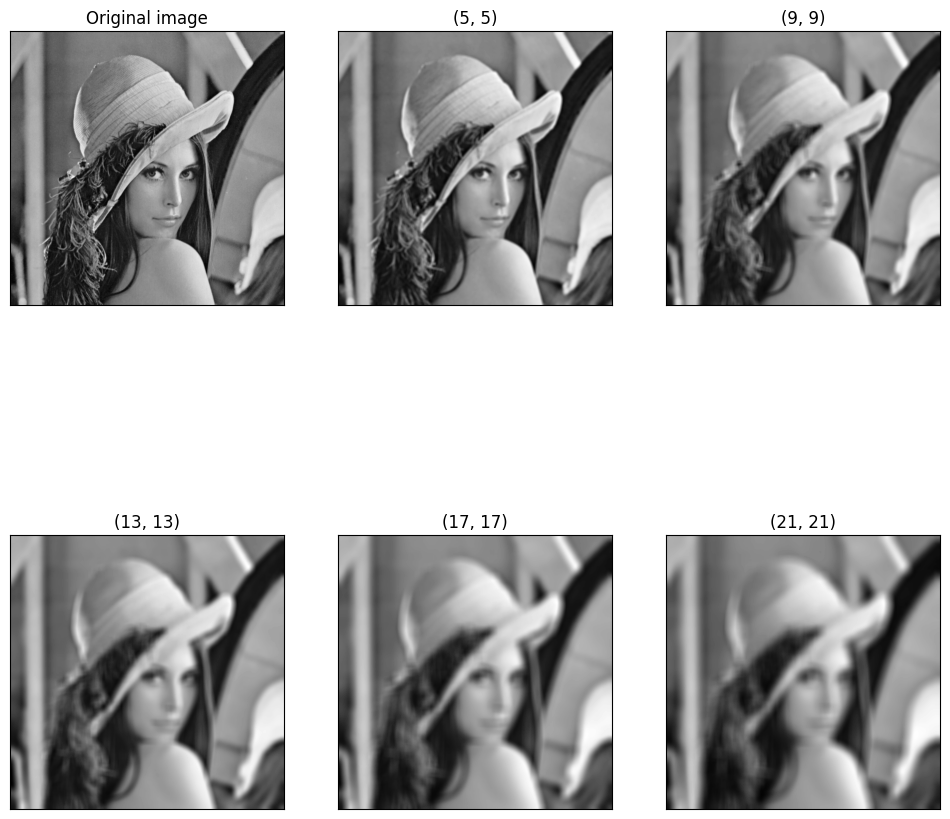

In [43]:
lenna = cv2.imread("../data/images/lenna.png", flags=cv2.IMREAD_GRAYSCALE)

# Filtersizes to use
k_sizes = [(i, i) for i in range(1, 22, 4)]
labels = [str(k) for k in k_sizes]
labels[0] = 'Original image'
# Apply mean-filtering with different filtersizes to the images
blur_images = [cv2.blur(lenna, ksize=k) for k in k_sizes]

# Plot images with different blur-levels
plot_images(blur_images, labels)

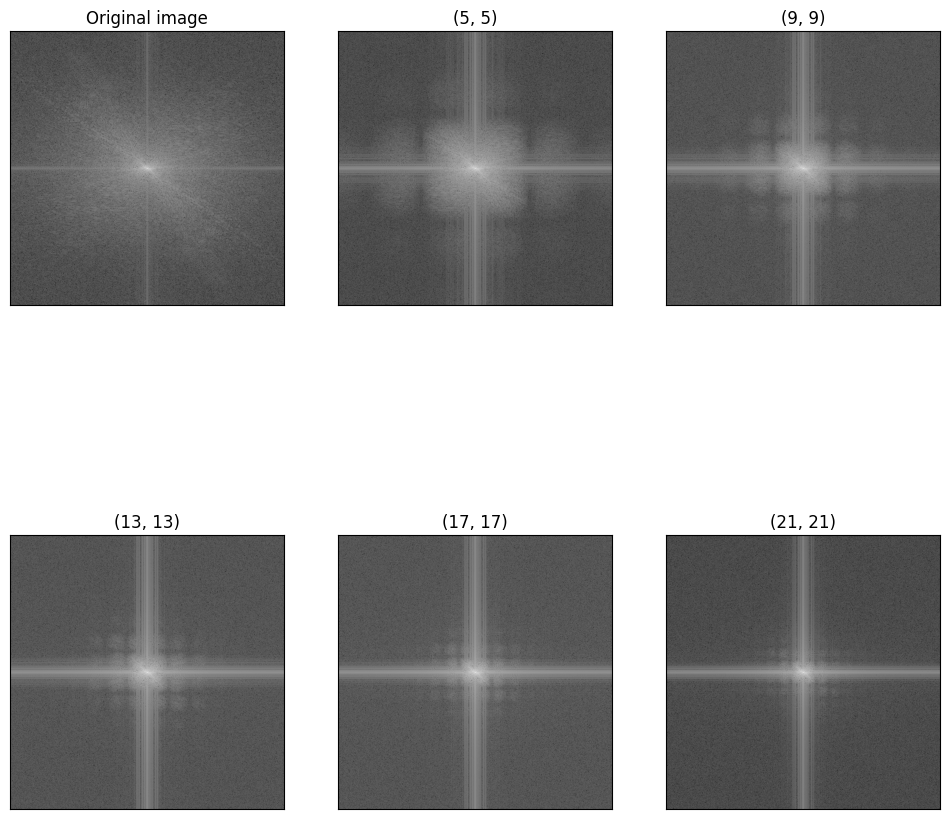

In [44]:
dft = np.fft.fft2
idft = np.fft.ifft2
shift = lambda G: np.fft.fftshift(G)
ishift = lambda G: np.fft.ifftshift(G)
mag = lambda G, scale=20: scale * (np.ma.log(np.abs(G))).filled(0)

# Take Fourier transform of the images
dfts = [dft(img) for img in blur_images]
# Shift the Foruier transformed images
dfts_shifted = [shift(G) for G in dfts]

# Plot the magnitudes of said images
plot_images([mag(G) for G in dfts_shifted], labels)

We can see from the magnitude plots, that the more blurry the image is, the less of the high-frequency bands are present in the magnitude plot.

In [45]:
# Parameters used to filter out the lower frequencies
(h, w) = lenna.shape
(centerX, centerY) = (int(w / 2.0), int(h / 2.0))
size = 50

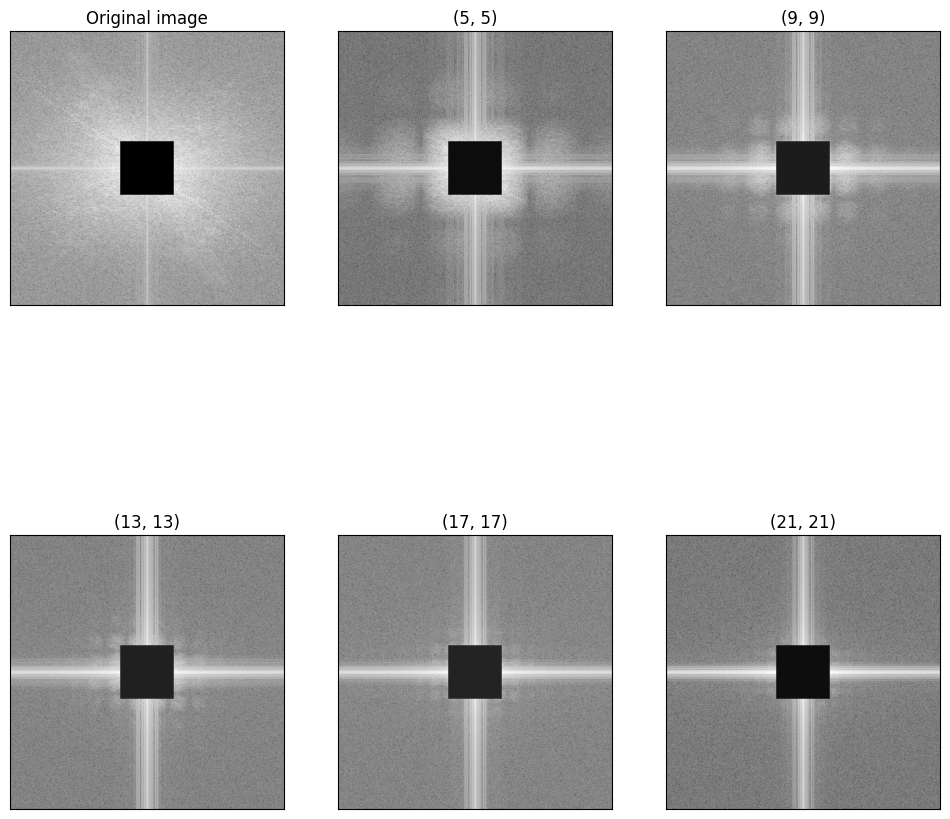

In [46]:
import copy

modified_shifted_dfts = []
for G in dfts_shifted:
    cG = copy.copy(G)
    cG[centerY - size : centerY + size, centerX - size:centerX + size] = 0
    modified_shifted_dfts.append(cG)

# We remove the lower frequencies form the frequency domain
plot_images([mag(mod_G) for mod_G in modified_shifted_dfts], labels)

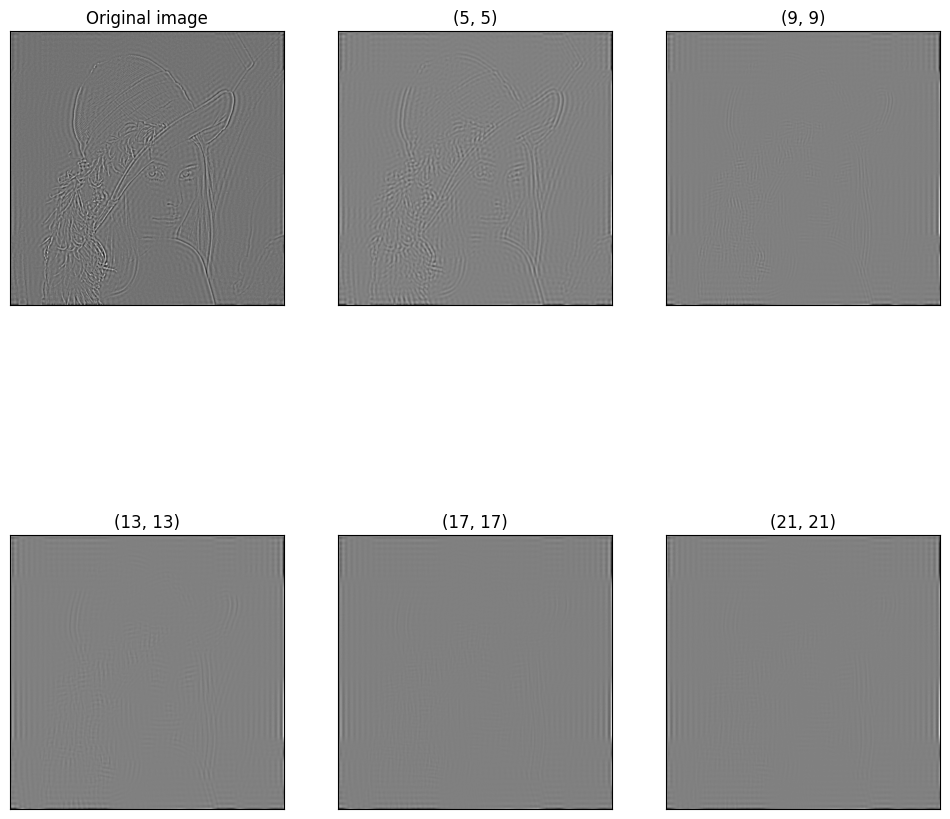

In [47]:
# Reconstruct the images
recon = [
    np.real(
    idft(ishift(mod_G))
    ) for mod_G in modified_shifted_dfts]
    
plot_images(recon, labels)

Sharpness of an image <=> More information is stored in the higher frequencies.
I.e. blurry images have most of its information stored in the lower frequencies, meaining you will lost almost all image information when you remove the lower frequencies from the frequency-domain, and then reconstructiong the image.

As the edgs in the reconstructed images are shown both with high and low pixel values (i.e. white and black colors on the image above), we can take the magnitude of the reconstructed images to see if there are any preserved edges after we are done with our reconstruction

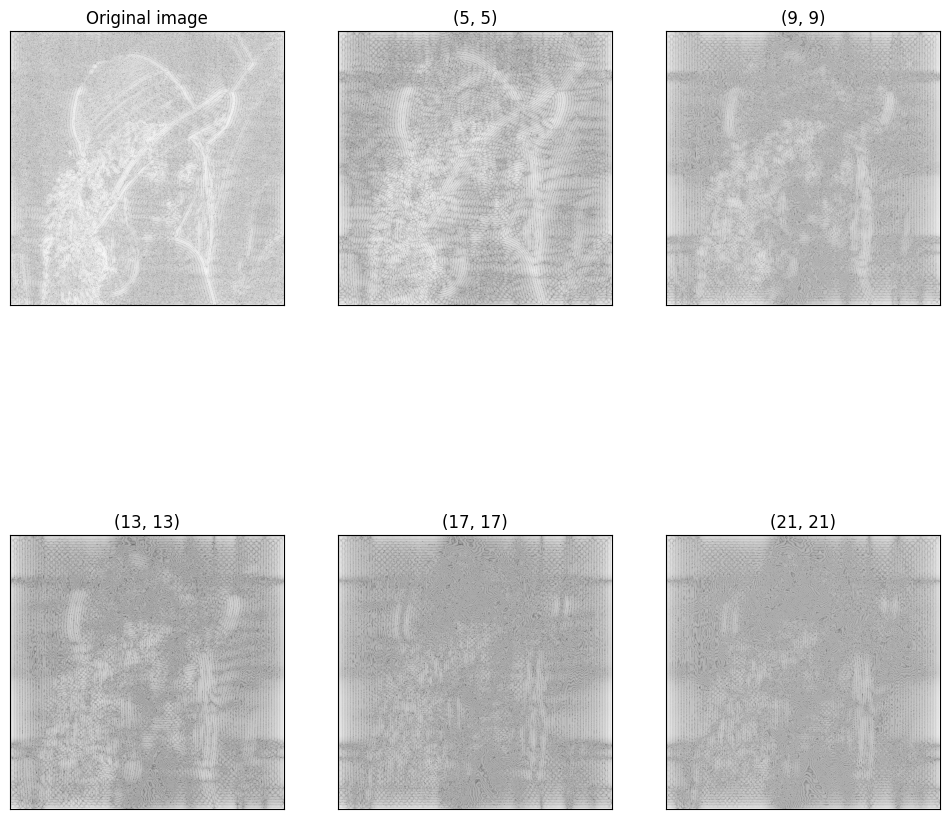

In [48]:
mags_of_recon = [mag(img) for img in recon]
plot_images(mags_of_recon, labels)

For each image, by taking the mean of the magnitude, will give us a number for how much of the edges are preserved after the reconstruction:

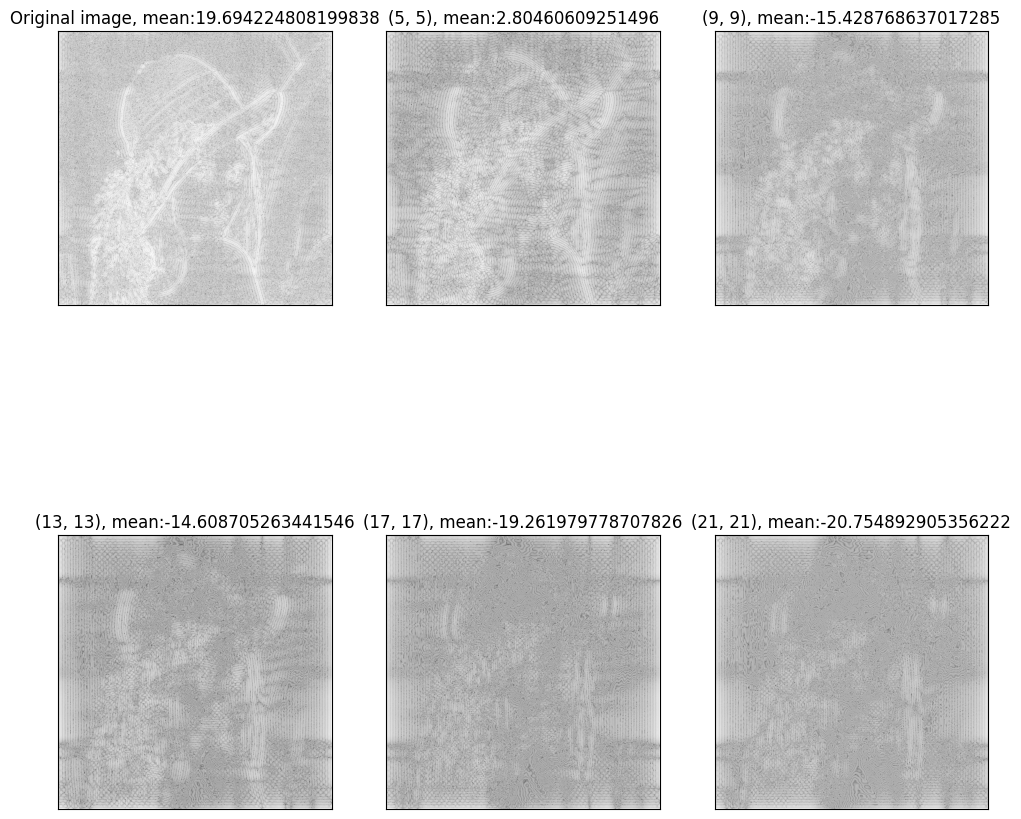

In [49]:
mag_recon_labels = []
for img, lab in zip(mags_of_recon, labels):
    mag_recon_labels.append(f'{lab}, mean:{np.mean(img)}')

plot_images(mags_of_recon, mag_recon_labels)

It looks like the mean of the magnitude of the reconstructed image is a good metric when it comes to determining if the image is sharp or not.

Also; in order to normalize these 'mean-values' we will need to normalize the pixel values into 0-255 before calculating the magnitude which we will do in the actual algorithm.

The hard part will be to tune the correct size and threshold parameters to work for most cases.